# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.608174476425488 -3.2657039027049417
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size, lstm_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # GRU: Gated Recurrent Units
    gru = tf.nn.rnn_cell.GRUCell(lstm_size) # hidden size
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    g_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    d_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    return states, actions, targetQs, cell, g_initial_state, d_initial_state

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# MLP & Conv
# # Generator/Controller: Generating/prediting the actions
# def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('generator', reuse=reuse):
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=states, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=action_size)        
#         #predictions = tf.nn.softmax(logits)

#         # return actions logits
#         return logits

In [17]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [18]:
# MLP & Conv
# # Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
# def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('discriminator', reuse=reuse):
#         # Fusion/merge states and actions/ SA/ SM
#         x_fused = tf.concat(axis=1, values=[states, actions])
        
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=1)        
#         #predictions = tf.nn.softmax(logits)

#         # return rewards logits
#         return logits

In [19]:
# RNN generator or sequence generator
def discriminator(states, actions, initial_state, cell, lstm_size, reuse=False): 
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        inputs = tf.layers.dense(inputs=x_fused, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=1)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [20]:
def model_loss(action_size, hidden_size, states, actions, targetQs,
               cell, g_initial_state, d_initial_state):
    # G/Actor
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_logits, g_final_state = generator(states=states, num_classes=action_size, 
                                              cell=cell, initial_state=g_initial_state, lstm_size=hidden_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs)
    
    # D/Critic
    #Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    Qs_logits, d_final_state = discriminator(states=states, actions=actions_logits, 
                                             cell=cell, initial_state=d_initial_state, lstm_size=hidden_size)
    d_lossQ = tf.reduce_mean(tf.square(tf.reshape(Qs_logits, [-1]) - targetQs))
    d_lossQ_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                          labels=tf.nn.sigmoid(targetQs)))
    d_loss = d_lossQ_sigm + d_lossQ

    return actions_logits, Qs_logits, g_final_state, d_final_state, g_loss, d_loss, d_lossQ, d_lossQ_sigm

In [21]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize RNN
    # g_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(g_loss, g_vars), clip_norm=5) # usually around 1-5
    # d_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(d_loss, d_vars), clip_norm=5) # usually around 1-5
    g_grads=tf.gradients(g_loss, g_vars)
    d_grads=tf.gradients(d_loss, d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(g_grads, g_vars))
    d_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(d_grads, d_vars))
    
    # # Optimize MLP & CNN
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    #     g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    #     d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [22]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, cell, self.g_initial_state, self.d_initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_final_state, self.d_final_state, self.g_loss, self.d_loss, self.d_lossQ, self.d_lossQ_sigm = model_loss(
            action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, cell=cell, targetQs=self.targetQs,
            g_initial_state=self.g_initial_state, d_initial_state=self.d_initial_state)
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [23]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [24]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [25]:
# Training parameters
# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 64                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

In [26]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 1)


In [27]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

In [28]:
memory.buffer[0]

[array([-0.03574145,  0.04045201, -0.03310713,  0.04148126]),
 0,
 array([-0.03493241, -0.15417994, -0.03227751,  0.32353748]),
 1.0,
 0.0]

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
from collections import deque
episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossQ_list, d_lossQsigm_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        state = env.reset() # env first state
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)

        # Training steps/batches
        while True:
            # Testing/inference
            action_logits, g_final_state, d_final_state = sess.run(
                fetches=[model.actions_logits, model.g_final_state, model.d_final_state], 
                feed_dict={model.states: np.reshape(state, [1, -1]),
                           model.g_initial_state: g_initial_state,
                           model.d_initial_state: d_initial_state})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([g_initial_state, g_final_state,
                                  d_initial_state, d_final_state])
            total_reward += reward
            g_initial_state = g_final_state
            d_initial_state = d_final_state
            state = next_state
            
            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            g_initial_states = np.array([each[0] for each in rnn_states])
            g_final_states = np.array([each[1] for each in rnn_states])
            d_initial_states = np.array([each[2] for each in rnn_states])
            d_final_states = np.array([each[3] for each in rnn_states])
            nextQs_logits = sess.run(fetches = model.Qs_logits,
                                     feed_dict = {model.states: next_states, 
                                                  model.g_initial_state: g_final_states[0].reshape([1, -1]),
                                                  model.d_initial_state: d_final_states[0].reshape([1, -1])})
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # exploit
            targetQs = rewards + (0.99 * nextQs)
            g_loss, d_loss, d_lossQ, d_lossQsigm, _, _ = sess.run(
                fetches=[model.g_loss, model.d_loss, 
                         model.d_lossQ, model.d_lossQ_sigm,
                         model.g_opt, model.d_opt], 
                feed_dict = {model.states: states, model.actions: actions,
                             model.targetQs: targetQs,
                             model.g_initial_state: g_initial_states[0].reshape([1, -1]),
                             model.d_initial_state: d_initial_states[0].reshape([1, -1])})

            if done is True:
                break

        # Episode total reward and success rate/prob
        episode_reward.append(total_reward) # stopping criteria
        rate = total_reward/ 500 # success is 500 points: 0-1
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossQ:{:.4f}'.format(d_lossQ),
              'dlossQsigm:{:.4f}'.format(d_lossQsigm))
        # Ploting out
        rewards_list.append([ep, np.mean(episode_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossQ_list.append([ep, d_lossQ])
        d_lossQsigm_list.append([ep, d_lossQsigm])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-seq.ckpt')

Episode:0 meanR:34.0000 rate:0.0680 gloss:1.1535 dloss:1.4722 dlossQ:1.0212 dlossQsigm:0.4510
Episode:1 meanR:27.5000 rate:0.0420 gloss:1.0895 dloss:1.4990 dlossQ:1.1671 dlossQsigm:0.3318
Episode:2 meanR:26.6667 rate:0.0500 gloss:0.9433 dloss:1.6428 dlossQ:1.4878 dlossQsigm:0.1549
Episode:3 meanR:32.0000 rate:0.0960 gloss:0.1668 dloss:2.6471 dlossQ:2.5697 dlossQsigm:0.0774
Episode:4 meanR:34.4000 rate:0.0880 gloss:0.0060 dloss:3.1053 dlossQ:3.0267 dlossQsigm:0.0786
Episode:5 meanR:32.6667 rate:0.0480 gloss:0.3092 dloss:3.7294 dlossQ:3.6459 dlossQsigm:0.0836
Episode:6 meanR:33.1429 rate:0.0720 gloss:0.0246 dloss:6.4472 dlossQ:6.3068 dlossQsigm:0.1404
Episode:7 meanR:38.7500 rate:0.1560 gloss:0.4370 dloss:1.1286 dlossQ:1.1030 dlossQsigm:0.0256
Episode:8 meanR:40.4444 rate:0.1080 gloss:0.0609 dloss:9.9063 dlossQ:9.7594 dlossQsigm:0.1469
Episode:9 meanR:38.7000 rate:0.0460 gloss:0.0005 dloss:12.7975 dlossQ:12.6284 dlossQsigm:0.1692
Episode:10 meanR:37.3636 rate:0.0480 gloss:0.0021 dloss:7.

Episode:87 meanR:38.7614 rate:0.0840 gloss:0.0000 dloss:1.1275 dlossQ:1.0361 dlossQsigm:0.0914
Episode:88 meanR:38.6404 rate:0.0560 gloss:0.0001 dloss:0.7812 dlossQ:0.7282 dlossQsigm:0.0529
Episode:89 meanR:38.8778 rate:0.1200 gloss:0.0000 dloss:1.2253 dlossQ:1.1616 dlossQsigm:0.0637
Episode:90 meanR:38.7253 rate:0.0500 gloss:0.0000 dloss:1.1276 dlossQ:1.0414 dlossQsigm:0.0862
Episode:91 meanR:38.9348 rate:0.1160 gloss:0.0160 dloss:1.2765 dlossQ:0.9960 dlossQsigm:0.2805
Episode:92 meanR:39.0108 rate:0.0920 gloss:0.0015 dloss:3.9559 dlossQ:3.9009 dlossQsigm:0.0550
Episode:93 meanR:39.3404 rate:0.1400 gloss:0.0010 dloss:1.2605 dlossQ:1.2323 dlossQsigm:0.0282
Episode:94 meanR:39.3474 rate:0.0800 gloss:0.0006 dloss:3.5330 dlossQ:3.4815 dlossQsigm:0.0515
Episode:95 meanR:39.7604 rate:0.1580 gloss:0.0000 dloss:0.9046 dlossQ:0.8742 dlossQsigm:0.0304
Episode:96 meanR:39.9278 rate:0.1120 gloss:0.0000 dloss:0.4724 dlossQ:0.3689 dlossQsigm:0.1035
Episode:97 meanR:40.0000 rate:0.0940 gloss:0.0013 

Episode:173 meanR:36.4400 rate:0.0600 gloss:0.0000 dloss:0.6248 dlossQ:0.5723 dlossQsigm:0.0525
Episode:174 meanR:36.4200 rate:0.0560 gloss:0.0000 dloss:0.5341 dlossQ:0.4636 dlossQsigm:0.0705
Episode:175 meanR:36.3900 rate:0.0440 gloss:0.0000 dloss:0.4156 dlossQ:0.3282 dlossQsigm:0.0874
Episode:176 meanR:36.1500 rate:0.0520 gloss:0.0000 dloss:0.4222 dlossQ:0.3334 dlossQsigm:0.0888
Episode:177 meanR:36.1100 rate:0.1000 gloss:0.0001 dloss:0.8989 dlossQ:0.8574 dlossQsigm:0.0415
Episode:178 meanR:36.1500 rate:0.0600 gloss:0.0000 dloss:1.6104 dlossQ:1.5185 dlossQsigm:0.0918
Episode:179 meanR:36.3300 rate:0.0900 gloss:0.0001 dloss:0.6780 dlossQ:0.6390 dlossQsigm:0.0390
Episode:180 meanR:35.9700 rate:0.0520 gloss:0.0000 dloss:1.0522 dlossQ:1.0133 dlossQsigm:0.0389
Episode:181 meanR:36.0300 rate:0.0640 gloss:0.0001 dloss:1.5795 dlossQ:1.5231 dlossQsigm:0.0564
Episode:182 meanR:36.1000 rate:0.1220 gloss:0.0000 dloss:0.7458 dlossQ:0.6705 dlossQsigm:0.0753
Episode:183 meanR:35.9500 rate:0.0500 gl

Episode:259 meanR:35.9400 rate:0.1240 gloss:0.0000 dloss:1.0686 dlossQ:0.9313 dlossQsigm:0.1373
Episode:260 meanR:36.1300 rate:0.0800 gloss:0.0000 dloss:0.6465 dlossQ:0.4726 dlossQsigm:0.1738
Episode:261 meanR:36.3900 rate:0.1000 gloss:0.0001 dloss:1.4238 dlossQ:1.3663 dlossQsigm:0.0575
Episode:262 meanR:36.5000 rate:0.0820 gloss:0.0001 dloss:2.1829 dlossQ:2.1403 dlossQsigm:0.0427
Episode:263 meanR:36.3600 rate:0.0480 gloss:0.0000 dloss:1.3318 dlossQ:1.2259 dlossQsigm:0.1059
Episode:264 meanR:36.4700 rate:0.0700 gloss:0.0000 dloss:1.4275 dlossQ:1.3532 dlossQsigm:0.0744
Episode:265 meanR:36.5600 rate:0.0980 gloss:0.0000 dloss:0.4134 dlossQ:0.3580 dlossQsigm:0.0554
Episode:266 meanR:37.0200 rate:0.1560 gloss:0.0001 dloss:2.0226 dlossQ:1.9863 dlossQsigm:0.0362
Episode:267 meanR:36.8400 rate:0.0640 gloss:0.0000 dloss:1.5908 dlossQ:1.5400 dlossQsigm:0.0509
Episode:268 meanR:36.6200 rate:0.0480 gloss:0.0000 dloss:1.1935 dlossQ:1.1066 dlossQsigm:0.0869
Episode:269 meanR:36.4400 rate:0.0680 gl

Episode:345 meanR:38.2100 rate:0.0480 gloss:0.0126 dloss:1.4265 dlossQ:1.3536 dlossQsigm:0.0728
Episode:346 meanR:38.1200 rate:0.0980 gloss:0.0002 dloss:4.6178 dlossQ:4.5419 dlossQsigm:0.0759
Episode:347 meanR:38.2300 rate:0.1380 gloss:0.0018 dloss:3.4862 dlossQ:3.4358 dlossQsigm:0.0504
Episode:348 meanR:38.4500 rate:0.1360 gloss:0.0000 dloss:7.4827 dlossQ:7.4204 dlossQsigm:0.0623
Episode:349 meanR:38.3600 rate:0.0620 gloss:0.0000 dloss:6.0784 dlossQ:6.0389 dlossQsigm:0.0394
Episode:350 meanR:38.5600 rate:0.1040 gloss:0.0000 dloss:2.4892 dlossQ:2.3312 dlossQsigm:0.1579
Episode:351 meanR:38.4800 rate:0.0680 gloss:-0.0000 dloss:1.9617 dlossQ:1.6979 dlossQsigm:0.2637
Episode:352 meanR:38.8400 rate:0.1180 gloss:0.0020 dloss:4.7047 dlossQ:4.6220 dlossQsigm:0.0827
Episode:353 meanR:38.6300 rate:0.0560 gloss:0.0006 dloss:6.7117 dlossQ:6.4976 dlossQsigm:0.2142
Episode:354 meanR:38.7000 rate:0.0760 gloss:-0.0000 dloss:2.5491 dlossQ:2.2090 dlossQsigm:0.3400
Episode:355 meanR:38.6900 rate:0.0460 

Episode:431 meanR:41.5400 rate:0.0480 gloss:0.0006 dloss:5.1678 dlossQ:4.7779 dlossQsigm:0.3899
Episode:432 meanR:41.5400 rate:0.0560 gloss:0.0001 dloss:7.4027 dlossQ:7.2222 dlossQsigm:0.1805
Episode:433 meanR:41.5300 rate:0.0460 gloss:0.0000 dloss:3.7552 dlossQ:3.6674 dlossQsigm:0.0879
Episode:434 meanR:41.2200 rate:0.0440 gloss:0.0001 dloss:4.8736 dlossQ:4.7825 dlossQsigm:0.0910
Episode:435 meanR:41.5900 rate:0.1240 gloss:0.0001 dloss:1.6949 dlossQ:1.5965 dlossQsigm:0.0984
Episode:436 meanR:41.7700 rate:0.0920 gloss:0.0000 dloss:4.9872 dlossQ:4.9274 dlossQsigm:0.0598
Episode:437 meanR:41.8400 rate:0.0620 gloss:0.0000 dloss:2.9747 dlossQ:2.8848 dlossQsigm:0.0899
Episode:438 meanR:40.7900 rate:0.0600 gloss:0.0000 dloss:1.3857 dlossQ:1.1364 dlossQsigm:0.2492
Episode:439 meanR:40.5900 rate:0.0860 gloss:0.0000 dloss:1.4233 dlossQ:1.2565 dlossQsigm:0.1668
Episode:440 meanR:40.6800 rate:0.1140 gloss:0.0186 dloss:3.2544 dlossQ:3.1780 dlossQsigm:0.0764
Episode:441 meanR:40.3700 rate:0.0440 gl

Episode:517 meanR:38.2900 rate:0.0760 gloss:0.0000 dloss:1.0182 dlossQ:0.9706 dlossQsigm:0.0476
Episode:518 meanR:37.8400 rate:0.0400 gloss:0.0000 dloss:1.2030 dlossQ:1.1363 dlossQsigm:0.0667
Episode:519 meanR:37.8200 rate:0.0440 gloss:0.0000 dloss:0.9801 dlossQ:0.9194 dlossQsigm:0.0607
Episode:520 meanR:38.1300 rate:0.1220 gloss:0.0000 dloss:1.2072 dlossQ:1.1460 dlossQsigm:0.0612
Episode:521 meanR:37.9700 rate:0.0620 gloss:0.0001 dloss:2.3859 dlossQ:2.3380 dlossQsigm:0.0478
Episode:522 meanR:37.7000 rate:0.0560 gloss:0.0001 dloss:2.5316 dlossQ:2.4539 dlossQsigm:0.0777
Episode:523 meanR:37.6600 rate:0.1060 gloss:0.0001 dloss:1.3286 dlossQ:1.2828 dlossQsigm:0.0458
Episode:524 meanR:37.5400 rate:0.0700 gloss:0.0000 dloss:1.8516 dlossQ:1.8022 dlossQsigm:0.0494
Episode:525 meanR:37.7700 rate:0.1000 gloss:0.0000 dloss:0.9516 dlossQ:0.9066 dlossQsigm:0.0450
Episode:526 meanR:37.3300 rate:0.0440 gloss:0.0000 dloss:1.4503 dlossQ:1.3986 dlossQsigm:0.0517
Episode:527 meanR:37.1700 rate:0.0660 gl

Episode:603 meanR:38.9500 rate:0.0520 gloss:0.0000 dloss:2.4936 dlossQ:2.4181 dlossQsigm:0.0755
Episode:604 meanR:39.3200 rate:0.1720 gloss:0.0000 dloss:4.7984 dlossQ:4.7331 dlossQsigm:0.0653
Episode:605 meanR:39.3800 rate:0.0600 gloss:0.0000 dloss:7.5055 dlossQ:7.3842 dlossQsigm:0.1213
Episode:606 meanR:39.2900 rate:0.0480 gloss:0.0000 dloss:7.5857 dlossQ:7.4218 dlossQsigm:0.1639
Episode:607 meanR:39.2400 rate:0.0440 gloss:0.0000 dloss:4.5070 dlossQ:4.3812 dlossQsigm:0.1258
Episode:608 meanR:39.3900 rate:0.0780 gloss:0.0000 dloss:3.5401 dlossQ:3.4295 dlossQsigm:0.1106
Episode:609 meanR:39.6900 rate:0.1260 gloss:0.0029 dloss:2.3434 dlossQ:2.2317 dlossQsigm:0.1117
Episode:610 meanR:39.2900 rate:0.0460 gloss:0.0004 dloss:3.4334 dlossQ:3.3606 dlossQsigm:0.0728
Episode:611 meanR:39.3700 rate:0.0680 gloss:0.0038 dloss:1.2480 dlossQ:1.1118 dlossQsigm:0.1362
Episode:612 meanR:39.0700 rate:0.0560 gloss:0.0000 dloss:2.3513 dlossQ:2.2572 dlossQsigm:0.0940
Episode:613 meanR:38.9200 rate:0.0600 gl

Episode:689 meanR:39.8900 rate:0.0860 gloss:0.0000 dloss:1.7726 dlossQ:1.7264 dlossQsigm:0.0461
Episode:690 meanR:39.8300 rate:0.0440 gloss:0.0000 dloss:1.5775 dlossQ:1.5279 dlossQsigm:0.0496
Episode:691 meanR:39.7000 rate:0.0460 gloss:0.0000 dloss:2.7802 dlossQ:2.6962 dlossQsigm:0.0840
Episode:692 meanR:39.8900 rate:0.0940 gloss:0.0000 dloss:1.8269 dlossQ:1.7748 dlossQsigm:0.0521
Episode:693 meanR:39.8100 rate:0.0580 gloss:0.0000 dloss:1.0842 dlossQ:1.0405 dlossQsigm:0.0437
Episode:694 meanR:39.8800 rate:0.1500 gloss:0.0010 dloss:2.9284 dlossQ:2.8772 dlossQsigm:0.0511
Episode:695 meanR:39.7100 rate:0.0520 gloss:0.0003 dloss:8.5306 dlossQ:8.4116 dlossQsigm:0.1190
Episode:696 meanR:39.8700 rate:0.1340 gloss:0.0004 dloss:4.4616 dlossQ:4.4013 dlossQsigm:0.0604
Episode:697 meanR:39.6500 rate:0.0600 gloss:0.0001 dloss:6.5444 dlossQ:6.4508 dlossQsigm:0.0936
Episode:698 meanR:39.6400 rate:0.0480 gloss:0.0001 dloss:5.1051 dlossQ:4.9936 dlossQsigm:0.1115
Episode:699 meanR:39.9100 rate:0.1120 gl

Episode:775 meanR:41.0900 rate:0.0520 gloss:0.0000 dloss:1.7648 dlossQ:1.3174 dlossQsigm:0.4474
Episode:776 meanR:41.2800 rate:0.1360 gloss:0.0000 dloss:6.1497 dlossQ:6.1097 dlossQsigm:0.0400
Episode:777 meanR:41.4100 rate:0.1020 gloss:0.0000 dloss:2.2074 dlossQ:2.1382 dlossQsigm:0.0692
Episode:778 meanR:41.6300 rate:0.1220 gloss:0.0045 dloss:3.5555 dlossQ:3.4859 dlossQsigm:0.0696
Episode:779 meanR:41.5500 rate:0.0480 gloss:0.0009 dloss:3.3642 dlossQ:3.1812 dlossQsigm:0.1830
Episode:780 meanR:41.5700 rate:0.0520 gloss:0.0004 dloss:3.4860 dlossQ:3.0428 dlossQsigm:0.4432
Episode:781 meanR:41.5000 rate:0.0480 gloss:0.0000 dloss:1.5134 dlossQ:1.4274 dlossQsigm:0.0860
Episode:782 meanR:41.4100 rate:0.1120 gloss:0.0000 dloss:3.5693 dlossQ:3.4950 dlossQsigm:0.0743
Episode:783 meanR:41.5600 rate:0.0840 gloss:0.0000 dloss:2.1069 dlossQ:2.0523 dlossQsigm:0.0546
Episode:784 meanR:41.4700 rate:0.0460 gloss:0.0000 dloss:1.5956 dlossQ:1.5387 dlossQsigm:0.0568
Episode:785 meanR:41.5900 rate:0.1160 gl

Episode:861 meanR:40.4400 rate:0.1020 gloss:0.0008 dloss:5.0749 dlossQ:4.9812 dlossQsigm:0.0938
Episode:862 meanR:40.4100 rate:0.0480 gloss:0.0000 dloss:4.0969 dlossQ:3.9337 dlossQsigm:0.1632
Episode:863 meanR:40.2000 rate:0.0560 gloss:0.0000 dloss:2.1231 dlossQ:1.8935 dlossQsigm:0.2297
Episode:864 meanR:40.2300 rate:0.0540 gloss:0.0000 dloss:0.8437 dlossQ:0.7763 dlossQsigm:0.0674
Episode:865 meanR:40.1300 rate:0.0440 gloss:0.0000 dloss:0.8095 dlossQ:0.7474 dlossQsigm:0.0622
Episode:866 meanR:40.0400 rate:0.0500 gloss:0.0000 dloss:1.0169 dlossQ:0.9542 dlossQsigm:0.0627
Episode:867 meanR:40.0800 rate:0.0680 gloss:0.0000 dloss:1.1409 dlossQ:1.0784 dlossQsigm:0.0626
Episode:868 meanR:39.5900 rate:0.0580 gloss:0.0000 dloss:1.0943 dlossQ:1.0308 dlossQsigm:0.0635
Episode:869 meanR:39.3400 rate:0.0900 gloss:0.0000 dloss:1.5731 dlossQ:1.5194 dlossQsigm:0.0537
Episode:870 meanR:39.0100 rate:0.0420 gloss:0.0000 dloss:1.7138 dlossQ:1.6554 dlossQsigm:0.0584
Episode:871 meanR:38.7700 rate:0.0760 gl

Episode:947 meanR:35.5400 rate:0.0700 gloss:0.0000 dloss:2.4432 dlossQ:2.3546 dlossQsigm:0.0886
Episode:948 meanR:35.6300 rate:0.0680 gloss:0.0000 dloss:0.7936 dlossQ:0.7025 dlossQsigm:0.0911
Episode:949 meanR:35.7100 rate:0.0640 gloss:0.0000 dloss:1.2918 dlossQ:1.2484 dlossQsigm:0.0434
Episode:950 meanR:35.8400 rate:0.1140 gloss:0.0008 dloss:5.6196 dlossQ:5.5320 dlossQsigm:0.0876
Episode:951 meanR:35.7100 rate:0.1160 gloss:0.0008 dloss:7.9566 dlossQ:7.8327 dlossQsigm:0.1239
Episode:952 meanR:35.7600 rate:0.1360 gloss:0.0001 dloss:3.2540 dlossQ:3.2002 dlossQsigm:0.0538
Episode:953 meanR:36.1800 rate:0.1600 gloss:0.0002 dloss:3.7685 dlossQ:3.7159 dlossQsigm:0.0526
Episode:954 meanR:36.0300 rate:0.0600 gloss:0.0001 dloss:3.1437 dlossQ:2.9285 dlossQsigm:0.2152
Episode:955 meanR:35.7300 rate:0.0440 gloss:0.0000 dloss:2.5275 dlossQ:2.4447 dlossQsigm:0.0828
Episode:956 meanR:35.8400 rate:0.0680 gloss:0.0000 dloss:3.0634 dlossQ:2.9966 dlossQsigm:0.0668
Episode:957 meanR:35.8500 rate:0.0440 gl

Episode:1032 meanR:38.7200 rate:0.0540 gloss:0.0000 dloss:3.8460 dlossQ:3.4954 dlossQsigm:0.3506
Episode:1033 meanR:38.8900 rate:0.1500 gloss:0.0000 dloss:1.3603 dlossQ:1.3425 dlossQsigm:0.0178
Episode:1034 meanR:39.2600 rate:0.1240 gloss:0.0015 dloss:2.5735 dlossQ:2.5364 dlossQsigm:0.0370
Episode:1035 meanR:39.2700 rate:0.0720 gloss:0.0002 dloss:2.8497 dlossQ:2.6425 dlossQsigm:0.2072
Episode:1036 meanR:39.4200 rate:0.0760 gloss:0.0000 dloss:0.8361 dlossQ:0.7847 dlossQsigm:0.0514
Episode:1037 meanR:39.4200 rate:0.0480 gloss:0.0000 dloss:0.9137 dlossQ:0.8540 dlossQsigm:0.0598
Episode:1038 meanR:39.7500 rate:0.1240 gloss:0.0000 dloss:2.4006 dlossQ:2.3545 dlossQsigm:0.0461
Episode:1039 meanR:39.9800 rate:0.0920 gloss:0.0000 dloss:3.4422 dlossQ:3.3630 dlossQsigm:0.0792
Episode:1040 meanR:39.9000 rate:0.0760 gloss:0.0000 dloss:3.5186 dlossQ:3.4308 dlossQsigm:0.0878
Episode:1041 meanR:39.8200 rate:0.0480 gloss:0.0000 dloss:2.9710 dlossQ:2.8794 dlossQsigm:0.0917
Episode:1042 meanR:39.9600 rat

Episode:1117 meanR:39.9100 rate:0.1800 gloss:0.0000 dloss:0.8589 dlossQ:0.8294 dlossQsigm:0.0295
Episode:1118 meanR:39.2300 rate:0.0500 gloss:0.0000 dloss:2.5977 dlossQ:2.5476 dlossQsigm:0.0501
Episode:1119 meanR:39.0700 rate:0.0580 gloss:0.0000 dloss:1.2150 dlossQ:1.1561 dlossQsigm:0.0589
Episode:1120 meanR:39.0800 rate:0.0500 gloss:0.0000 dloss:1.0540 dlossQ:0.9914 dlossQsigm:0.0626
Episode:1121 meanR:39.4700 rate:0.1640 gloss:0.0000 dloss:3.1593 dlossQ:3.1404 dlossQsigm:0.0189
Episode:1122 meanR:39.5100 rate:0.0540 gloss:0.0000 dloss:2.2999 dlossQ:2.2430 dlossQsigm:0.0569
Episode:1123 meanR:39.5000 rate:0.1220 gloss:0.0000 dloss:1.1214 dlossQ:1.0764 dlossQsigm:0.0450
Episode:1124 meanR:39.4900 rate:0.0660 gloss:0.0000 dloss:1.4080 dlossQ:1.3634 dlossQsigm:0.0446
Episode:1125 meanR:39.2300 rate:0.0620 gloss:0.0000 dloss:2.6203 dlossQ:2.5675 dlossQsigm:0.0528
Episode:1126 meanR:39.3100 rate:0.0580 gloss:0.0000 dloss:1.8932 dlossQ:1.8131 dlossQsigm:0.0801
Episode:1127 meanR:39.2100 rat

Episode:1202 meanR:38.1400 rate:0.1020 gloss:0.0000 dloss:4.4139 dlossQ:4.3303 dlossQsigm:0.0836
Episode:1203 meanR:38.1900 rate:0.0560 gloss:0.0000 dloss:5.4085 dlossQ:5.3203 dlossQsigm:0.0882
Episode:1204 meanR:37.9700 rate:0.0720 gloss:0.0000 dloss:3.3091 dlossQ:3.2466 dlossQsigm:0.0626
Episode:1205 meanR:38.1100 rate:0.1100 gloss:0.0000 dloss:3.5733 dlossQ:3.5121 dlossQsigm:0.0612
Episode:1206 meanR:37.8400 rate:0.0540 gloss:0.0000 dloss:4.4872 dlossQ:4.4092 dlossQsigm:0.0780
Episode:1207 meanR:38.1700 rate:0.1600 gloss:0.0000 dloss:4.4577 dlossQ:4.4005 dlossQsigm:0.0572
Episode:1208 meanR:38.0800 rate:0.0620 gloss:-0.0000 dloss:6.2960 dlossQ:6.0593 dlossQsigm:0.2367
Episode:1209 meanR:38.2600 rate:0.1480 gloss:0.0026 dloss:7.0772 dlossQ:7.0146 dlossQsigm:0.0626
Episode:1210 meanR:38.2600 rate:0.0700 gloss:0.0002 dloss:7.5774 dlossQ:7.4983 dlossQsigm:0.0791
Episode:1211 meanR:38.1000 rate:0.0620 gloss:0.0000 dloss:5.7824 dlossQ:5.6927 dlossQsigm:0.0897
Episode:1212 meanR:38.5700 ra

Episode:1287 meanR:36.3000 rate:0.0700 gloss:0.0000 dloss:1.5512 dlossQ:1.5111 dlossQsigm:0.0402
Episode:1288 meanR:36.3500 rate:0.0540 gloss:0.0000 dloss:1.5537 dlossQ:1.4981 dlossQsigm:0.0556
Episode:1289 meanR:36.9400 rate:0.1580 gloss:0.0000 dloss:12.5911 dlossQ:12.4832 dlossQsigm:0.1079
Episode:1290 meanR:36.7500 rate:0.0680 gloss:0.0000 dloss:25.2651 dlossQ:25.1439 dlossQsigm:0.1212
Episode:1291 meanR:36.8100 rate:0.0580 gloss:0.0000 dloss:16.0980 dlossQ:15.8886 dlossQsigm:0.2094
Episode:1292 meanR:36.8500 rate:0.0760 gloss:0.0000 dloss:11.1917 dlossQ:10.7943 dlossQsigm:0.3974
Episode:1293 meanR:36.7100 rate:0.0600 gloss:0.0000 dloss:1.6470 dlossQ:1.5978 dlossQsigm:0.0492
Episode:1294 meanR:36.7900 rate:0.0760 gloss:0.0000 dloss:0.8452 dlossQ:0.7938 dlossQsigm:0.0514
Episode:1295 meanR:37.1000 rate:0.1100 gloss:0.0000 dloss:8.7594 dlossQ:8.7101 dlossQsigm:0.0493
Episode:1296 meanR:37.0600 rate:0.0500 gloss:0.0000 dloss:3.2986 dlossQ:3.2654 dlossQsigm:0.0333
Episode:1297 meanR:37.

Episode:1371 meanR:38.4500 rate:0.0840 gloss:0.0000 dloss:2.0046 dlossQ:1.7072 dlossQsigm:0.2974
Episode:1372 meanR:38.6300 rate:0.0780 gloss:0.0000 dloss:1.2820 dlossQ:1.1425 dlossQsigm:0.1394
Episode:1373 meanR:38.6600 rate:0.0500 gloss:0.0000 dloss:1.7660 dlossQ:1.6618 dlossQsigm:0.1042
Episode:1374 meanR:38.7400 rate:0.0840 gloss:0.0000 dloss:4.5471 dlossQ:4.4816 dlossQsigm:0.0655
Episode:1375 meanR:38.8000 rate:0.0560 gloss:0.0000 dloss:1.7243 dlossQ:1.6546 dlossQsigm:0.0696
Episode:1376 meanR:38.7100 rate:0.0520 gloss:0.0000 dloss:2.3567 dlossQ:2.2051 dlossQsigm:0.1516
Episode:1377 meanR:38.6500 rate:0.0440 gloss:0.0000 dloss:2.5498 dlossQ:2.3678 dlossQsigm:0.1820
Episode:1378 meanR:38.2300 rate:0.0420 gloss:0.0000 dloss:2.0669 dlossQ:1.8013 dlossQsigm:0.2656
Episode:1379 meanR:38.1700 rate:0.0460 gloss:0.0000 dloss:1.6000 dlossQ:1.4701 dlossQsigm:0.1299
Episode:1380 meanR:38.1400 rate:0.0700 gloss:0.0000 dloss:1.6884 dlossQ:1.6148 dlossQsigm:0.0736
Episode:1381 meanR:38.3800 rat

Episode:1456 meanR:37.4300 rate:0.0800 gloss:0.0000 dloss:2.4812 dlossQ:2.4272 dlossQsigm:0.0540
Episode:1457 meanR:37.3100 rate:0.0480 gloss:0.0000 dloss:2.1826 dlossQ:1.8939 dlossQsigm:0.2886
Episode:1458 meanR:37.2200 rate:0.1200 gloss:0.0001 dloss:3.2806 dlossQ:3.2020 dlossQsigm:0.0786
Episode:1459 meanR:37.0400 rate:0.0440 gloss:0.0000 dloss:4.2511 dlossQ:4.1617 dlossQsigm:0.0895
Episode:1460 meanR:37.0900 rate:0.0520 gloss:0.0000 dloss:5.5260 dlossQ:5.4234 dlossQsigm:0.1026
Episode:1461 meanR:36.7700 rate:0.0540 gloss:0.0000 dloss:1.5392 dlossQ:1.4315 dlossQsigm:0.1077
Episode:1462 meanR:36.9500 rate:0.1040 gloss:0.0000 dloss:2.5843 dlossQ:2.5121 dlossQsigm:0.0722
Episode:1463 meanR:37.5000 rate:0.1680 gloss:0.0003 dloss:4.0898 dlossQ:4.0380 dlossQsigm:0.0518
Episode:1464 meanR:37.3300 rate:0.0640 gloss:0.0000 dloss:5.4677 dlossQ:5.3988 dlossQsigm:0.0689
Episode:1465 meanR:37.4800 rate:0.0900 gloss:0.0000 dloss:7.7653 dlossQ:7.6890 dlossQsigm:0.0762
Episode:1466 meanR:37.3100 rat

Episode:1541 meanR:38.0300 rate:0.0540 gloss:0.0000 dloss:2.9685 dlossQ:2.9268 dlossQsigm:0.0417
Episode:1542 meanR:37.9500 rate:0.1360 gloss:0.0000 dloss:8.0035 dlossQ:7.9315 dlossQsigm:0.0720
Episode:1543 meanR:37.8300 rate:0.0600 gloss:0.0000 dloss:4.5709 dlossQ:4.4393 dlossQsigm:0.1316
Episode:1544 meanR:37.7400 rate:0.0460 gloss:0.0000 dloss:3.7458 dlossQ:3.5050 dlossQsigm:0.2408
Episode:1545 meanR:37.3200 rate:0.0420 gloss:0.0000 dloss:1.7419 dlossQ:1.6730 dlossQsigm:0.0689
Episode:1546 meanR:37.4900 rate:0.1200 gloss:0.0000 dloss:7.3763 dlossQ:7.2687 dlossQsigm:0.1076
Episode:1547 meanR:37.2900 rate:0.0440 gloss:0.0000 dloss:4.8082 dlossQ:4.7156 dlossQsigm:0.0925
Episode:1548 meanR:37.2900 rate:0.0620 gloss:0.0000 dloss:6.7164 dlossQ:6.5254 dlossQsigm:0.1910
Episode:1549 meanR:37.1500 rate:0.0480 gloss:0.0000 dloss:2.1875 dlossQ:2.1092 dlossQsigm:0.0783
Episode:1550 meanR:37.1500 rate:0.0600 gloss:0.0000 dloss:1.9721 dlossQ:1.9071 dlossQsigm:0.0649
Episode:1551 meanR:36.8700 rat

Episode:1626 meanR:35.6200 rate:0.0680 gloss:0.0000 dloss:0.7846 dlossQ:0.6846 dlossQsigm:0.1000
Episode:1627 meanR:35.4400 rate:0.0420 gloss:0.0000 dloss:0.9230 dlossQ:0.8222 dlossQsigm:0.1008
Episode:1628 meanR:35.5000 rate:0.0580 gloss:0.0000 dloss:1.0311 dlossQ:0.9316 dlossQsigm:0.0995
Episode:1629 meanR:35.5100 rate:0.0540 gloss:0.0000 dloss:1.3559 dlossQ:1.2638 dlossQsigm:0.0921
Episode:1630 meanR:35.5100 rate:0.0580 gloss:0.0000 dloss:0.9244 dlossQ:0.8319 dlossQsigm:0.0925
Episode:1631 meanR:35.3600 rate:0.0760 gloss:0.0000 dloss:1.6792 dlossQ:1.6088 dlossQsigm:0.0704
Episode:1632 meanR:35.6400 rate:0.1060 gloss:0.0000 dloss:7.2251 dlossQ:7.1337 dlossQsigm:0.0914
Episode:1633 meanR:35.8800 rate:0.0960 gloss:0.0001 dloss:9.8454 dlossQ:9.7134 dlossQsigm:0.1320
Episode:1634 meanR:35.9200 rate:0.0480 gloss:0.0000 dloss:5.7227 dlossQ:5.6673 dlossQsigm:0.0554
Episode:1635 meanR:35.8700 rate:0.0520 gloss:0.0000 dloss:7.4812 dlossQ:7.3679 dlossQsigm:0.1132
Episode:1636 meanR:35.9500 rat

Episode:1711 meanR:36.6300 rate:0.0480 gloss:0.0000 dloss:2.1993 dlossQ:2.1373 dlossQsigm:0.0620
Episode:1712 meanR:36.9800 rate:0.1460 gloss:0.0000 dloss:9.4867 dlossQ:9.3887 dlossQsigm:0.0980
Episode:1713 meanR:36.8100 rate:0.0440 gloss:0.0000 dloss:10.5973 dlossQ:10.4821 dlossQsigm:0.1152
Episode:1714 meanR:36.9300 rate:0.0800 gloss:0.0000 dloss:8.1328 dlossQ:8.0031 dlossQsigm:0.1297
Episode:1715 meanR:37.2200 rate:0.1040 gloss:0.0000 dloss:2.1894 dlossQ:2.1291 dlossQsigm:0.0603
Episode:1716 meanR:37.2700 rate:0.0580 gloss:0.0000 dloss:3.1743 dlossQ:3.1235 dlossQsigm:0.0508
Episode:1717 meanR:37.4600 rate:0.0940 gloss:0.0000 dloss:6.7090 dlossQ:6.6131 dlossQsigm:0.0960
Episode:1718 meanR:37.5000 rate:0.0640 gloss:0.0000 dloss:10.0142 dlossQ:9.8868 dlossQsigm:0.1274
Episode:1719 meanR:37.6600 rate:0.0780 gloss:0.0000 dloss:1.4324 dlossQ:1.3830 dlossQsigm:0.0495
Episode:1720 meanR:37.2700 rate:0.0440 gloss:0.0000 dloss:2.1221 dlossQ:2.0529 dlossQsigm:0.0692
Episode:1721 meanR:37.5200 

Episode:1796 meanR:37.9800 rate:0.0760 gloss:0.0000 dloss:1.8017 dlossQ:1.7658 dlossQsigm:0.0358
Episode:1797 meanR:38.2100 rate:0.0900 gloss:0.0014 dloss:6.8305 dlossQ:6.7395 dlossQsigm:0.0910
Episode:1798 meanR:38.1500 rate:0.0660 gloss:0.0000 dloss:2.5773 dlossQ:2.5144 dlossQsigm:0.0630
Episode:1799 meanR:38.1400 rate:0.0520 gloss:0.0000 dloss:5.5506 dlossQ:5.4229 dlossQsigm:0.1277
Episode:1800 meanR:38.2000 rate:0.0680 gloss:0.0000 dloss:3.7325 dlossQ:3.6355 dlossQsigm:0.0970
Episode:1801 meanR:37.8600 rate:0.0520 gloss:0.0000 dloss:2.4762 dlossQ:2.3875 dlossQsigm:0.0886
Episode:1802 meanR:38.1400 rate:0.1100 gloss:0.0000 dloss:7.7101 dlossQ:7.5641 dlossQsigm:0.1460
Episode:1803 meanR:38.4100 rate:0.1020 gloss:0.0000 dloss:4.4210 dlossQ:4.1729 dlossQsigm:0.2482
Episode:1804 meanR:38.3800 rate:0.0580 gloss:0.0000 dloss:2.1474 dlossQ:2.0801 dlossQsigm:0.0673
Episode:1805 meanR:38.5900 rate:0.0980 gloss:0.0001 dloss:8.5127 dlossQ:8.4161 dlossQsigm:0.0967
Episode:1806 meanR:38.4800 rat

Episode:1881 meanR:40.1000 rate:0.0420 gloss:0.0000 dloss:28.4323 dlossQ:28.2936 dlossQsigm:0.1387
Episode:1882 meanR:40.1700 rate:0.0640 gloss:0.0000 dloss:29.6832 dlossQ:29.4089 dlossQsigm:0.2743
Episode:1883 meanR:39.9800 rate:0.0600 gloss:0.0000 dloss:8.0334 dlossQ:7.9252 dlossQsigm:0.1082
Episode:1884 meanR:39.9800 rate:0.1040 gloss:0.0001 dloss:10.9016 dlossQ:10.8242 dlossQsigm:0.0774
Episode:1885 meanR:39.6000 rate:0.0460 gloss:0.0000 dloss:13.7235 dlossQ:13.5996 dlossQsigm:0.1239
Episode:1886 meanR:39.9200 rate:0.1120 gloss:0.0016 dloss:25.0048 dlossQ:24.8108 dlossQsigm:0.1940
Episode:1887 meanR:39.9100 rate:0.0520 gloss:0.0000 dloss:42.2741 dlossQ:42.0326 dlossQsigm:0.2414
Episode:1888 meanR:39.8700 rate:0.0560 gloss:0.0000 dloss:44.3271 dlossQ:43.9936 dlossQsigm:0.3335
Episode:1889 meanR:40.2000 rate:0.1100 gloss:0.0000 dloss:27.6388 dlossQ:27.4115 dlossQsigm:0.2273
Episode:1890 meanR:39.7500 rate:0.0420 gloss:0.0000 dloss:37.6038 dlossQ:37.3393 dlossQsigm:0.2646
Episode:1891

Episode:1965 meanR:40.5000 rate:0.0500 gloss:0.0000 dloss:11.1495 dlossQ:11.0355 dlossQsigm:0.1140
Episode:1966 meanR:40.4600 rate:0.0860 gloss:0.0000 dloss:8.0016 dlossQ:7.9008 dlossQsigm:0.1008
Episode:1967 meanR:40.4400 rate:0.0520 gloss:0.0000 dloss:14.3626 dlossQ:14.2059 dlossQsigm:0.1566
Episode:1968 meanR:40.6200 rate:0.0880 gloss:0.0000 dloss:3.4945 dlossQ:3.4293 dlossQsigm:0.0652
Episode:1969 meanR:40.3300 rate:0.0500 gloss:0.0000 dloss:6.0937 dlossQ:5.9902 dlossQsigm:0.1035
Episode:1970 meanR:40.3600 rate:0.0800 gloss:0.0000 dloss:4.5779 dlossQ:4.4984 dlossQsigm:0.0796
Episode:1971 meanR:39.7700 rate:0.0780 gloss:0.0000 dloss:4.8099 dlossQ:4.7197 dlossQsigm:0.0902
Episode:1972 meanR:39.8000 rate:0.0500 gloss:0.0000 dloss:7.6982 dlossQ:7.5968 dlossQsigm:0.1014
Episode:1973 meanR:40.0200 rate:0.0920 gloss:0.0000 dloss:9.6000 dlossQ:9.4759 dlossQsigm:0.1241
Episode:1974 meanR:39.4700 rate:0.0960 gloss:0.0000 dloss:5.3707 dlossQ:5.2827 dlossQsigm:0.0879
Episode:1975 meanR:39.4500

Episode:2050 meanR:37.4700 rate:0.1100 gloss:0.0010 dloss:8.8813 dlossQ:8.7669 dlossQsigm:0.1144
Episode:2051 meanR:37.2900 rate:0.0940 gloss:0.0000 dloss:5.4010 dlossQ:5.3402 dlossQsigm:0.0609
Episode:2052 meanR:37.0400 rate:0.1120 gloss:0.0000 dloss:5.0804 dlossQ:4.9968 dlossQsigm:0.0836
Episode:2053 meanR:36.7800 rate:0.0600 gloss:0.0000 dloss:8.9558 dlossQ:8.8430 dlossQsigm:0.1128
Episode:2054 meanR:36.7000 rate:0.0660 gloss:0.0000 dloss:10.0183 dlossQ:9.8627 dlossQsigm:0.1555
Episode:2055 meanR:36.8300 rate:0.0680 gloss:0.0000 dloss:6.0052 dlossQ:5.9071 dlossQsigm:0.0981
Episode:2056 meanR:37.3000 rate:0.1440 gloss:0.0001 dloss:3.1179 dlossQ:3.0853 dlossQsigm:0.0326
Episode:2057 meanR:37.1500 rate:0.0700 gloss:0.0000 dloss:25.1177 dlossQ:24.9711 dlossQsigm:0.1467
Episode:2058 meanR:37.1100 rate:0.0460 gloss:0.0000 dloss:28.5273 dlossQ:28.2635 dlossQsigm:0.2638
Episode:2059 meanR:37.1700 rate:0.0880 gloss:0.0000 dloss:11.1711 dlossQ:11.0321 dlossQsigm:0.1390
Episode:2060 meanR:37.1

Episode:2135 meanR:36.8800 rate:0.1300 gloss:0.0000 dloss:3.8959 dlossQ:3.8519 dlossQsigm:0.0440
Episode:2136 meanR:36.9100 rate:0.0560 gloss:0.0000 dloss:6.1547 dlossQ:6.0743 dlossQsigm:0.0804
Episode:2137 meanR:36.8500 rate:0.0440 gloss:0.0000 dloss:4.6254 dlossQ:4.5146 dlossQsigm:0.1108
Episode:2138 meanR:36.6300 rate:0.0520 gloss:0.0000 dloss:3.0695 dlossQ:2.9685 dlossQsigm:0.1010
Episode:2139 meanR:37.4100 rate:0.2000 gloss:0.0000 dloss:3.6777 dlossQ:3.6137 dlossQsigm:0.0641
Episode:2140 meanR:37.3100 rate:0.0520 gloss:0.0000 dloss:9.3615 dlossQ:9.2222 dlossQsigm:0.1393
Episode:2141 meanR:37.2500 rate:0.0520 gloss:0.0000 dloss:10.4194 dlossQ:10.2282 dlossQsigm:0.1912
Episode:2142 meanR:37.3100 rate:0.0680 gloss:0.0000 dloss:3.2301 dlossQ:3.1436 dlossQsigm:0.0864
Episode:2143 meanR:37.3600 rate:0.0660 gloss:0.0000 dloss:2.8214 dlossQ:2.7506 dlossQsigm:0.0708
Episode:2144 meanR:37.0800 rate:0.0520 gloss:0.0000 dloss:3.1949 dlossQ:3.0919 dlossQsigm:0.1030
Episode:2145 meanR:37.4900 r

Episode:2220 meanR:35.6200 rate:0.1040 gloss:0.0000 dloss:3.6228 dlossQ:3.5662 dlossQsigm:0.0567
Episode:2221 meanR:36.2000 rate:0.2000 gloss:0.0002 dloss:3.5863 dlossQ:3.5342 dlossQsigm:0.0521
Episode:2222 meanR:36.3700 rate:0.0920 gloss:0.0000 dloss:6.4617 dlossQ:6.3890 dlossQsigm:0.0727
Episode:2223 meanR:36.2600 rate:0.0540 gloss:0.0000 dloss:4.3641 dlossQ:4.2871 dlossQsigm:0.0771
Episode:2224 meanR:36.5500 rate:0.1260 gloss:0.0000 dloss:6.5167 dlossQ:6.4194 dlossQsigm:0.0974
Episode:2225 meanR:36.6300 rate:0.0600 gloss:0.0000 dloss:5.1949 dlossQ:5.1148 dlossQsigm:0.0801
Episode:2226 meanR:36.5900 rate:0.0480 gloss:0.0000 dloss:6.2682 dlossQ:6.1469 dlossQsigm:0.1213
Episode:2227 meanR:36.6700 rate:0.0660 gloss:0.0000 dloss:3.2191 dlossQ:3.1608 dlossQsigm:0.0584
Episode:2228 meanR:36.4700 rate:0.0440 gloss:0.0000 dloss:3.1562 dlossQ:3.0950 dlossQsigm:0.0613
Episode:2229 meanR:36.4800 rate:0.0460 gloss:0.0000 dloss:1.9528 dlossQ:1.8978 dlossQsigm:0.0550
Episode:2230 meanR:36.5500 rat

Episode:2305 meanR:37.6600 rate:0.0580 gloss:0.0000 dloss:3.5991 dlossQ:3.5510 dlossQsigm:0.0481
Episode:2306 meanR:37.7500 rate:0.1060 gloss:0.0000 dloss:3.5922 dlossQ:3.5310 dlossQsigm:0.0612
Episode:2307 meanR:37.5500 rate:0.0480 gloss:0.0000 dloss:18.9075 dlossQ:17.9385 dlossQsigm:0.9690
Episode:2308 meanR:37.8500 rate:0.1200 gloss:0.0000 dloss:4.5007 dlossQ:4.3818 dlossQsigm:0.1189
Episode:2309 meanR:37.8600 rate:0.0720 gloss:0.0000 dloss:3.3759 dlossQ:3.3016 dlossQsigm:0.0743
Episode:2310 meanR:38.2600 rate:0.1300 gloss:0.0000 dloss:6.4292 dlossQ:6.3749 dlossQsigm:0.0543
Episode:2311 meanR:38.2500 rate:0.0440 gloss:0.0000 dloss:3.4523 dlossQ:3.3708 dlossQsigm:0.0816
Episode:2312 meanR:37.8800 rate:0.0680 gloss:0.0000 dloss:5.1418 dlossQ:5.0063 dlossQsigm:0.1355
Episode:2313 meanR:37.3800 rate:0.0500 gloss:0.0000 dloss:2.2001 dlossQ:1.9961 dlossQsigm:0.2040
Episode:2314 meanR:37.6000 rate:0.1220 gloss:0.0000 dloss:4.9054 dlossQ:4.7741 dlossQsigm:0.1312
Episode:2315 meanR:37.1300 r

Episode:2389 meanR:40.6500 rate:0.0940 gloss:-0.0000 dloss:5.6597 dlossQ:5.4938 dlossQsigm:0.1659
Episode:2390 meanR:40.8800 rate:0.1000 gloss:0.0000 dloss:9.7766 dlossQ:9.5592 dlossQsigm:0.2173
Episode:2391 meanR:41.3000 rate:0.1360 gloss:0.0000 dloss:6.5396 dlossQ:6.2552 dlossQsigm:0.2844
Episode:2392 meanR:41.3600 rate:0.0600 gloss:0.0000 dloss:11.5985 dlossQ:11.4740 dlossQsigm:0.1245
Episode:2393 meanR:40.8800 rate:0.0560 gloss:0.0000 dloss:20.1858 dlossQ:19.9326 dlossQsigm:0.2532
Episode:2394 meanR:40.7900 rate:0.0580 gloss:0.0000 dloss:7.8136 dlossQ:7.6872 dlossQsigm:0.1264
Episode:2395 meanR:40.4300 rate:0.0900 gloss:0.0000 dloss:3.0466 dlossQ:2.9842 dlossQsigm:0.0624
Episode:2396 meanR:40.8100 rate:0.1260 gloss:0.0000 dloss:3.3407 dlossQ:3.2879 dlossQsigm:0.0528
Episode:2397 meanR:40.7100 rate:0.0460 gloss:0.0000 dloss:3.0090 dlossQ:2.9589 dlossQsigm:0.0501
Episode:2398 meanR:40.8700 rate:0.0800 gloss:0.0000 dloss:1.2219 dlossQ:1.1407 dlossQsigm:0.0812
Episode:2399 meanR:40.870

Episode:2474 meanR:37.5900 rate:0.0680 gloss:0.0000 dloss:1.1329 dlossQ:1.0908 dlossQsigm:0.0421
Episode:2475 meanR:37.8200 rate:0.1460 gloss:0.0000 dloss:2.8826 dlossQ:2.8417 dlossQsigm:0.0409
Episode:2476 meanR:38.0100 rate:0.0900 gloss:0.0000 dloss:10.9992 dlossQ:10.8898 dlossQsigm:0.1094
Episode:2477 meanR:37.7500 rate:0.0500 gloss:0.0000 dloss:12.3211 dlossQ:12.1491 dlossQsigm:0.1720
Episode:2478 meanR:37.6700 rate:0.0500 gloss:0.0000 dloss:12.4537 dlossQ:12.2614 dlossQsigm:0.1923
Episode:2479 meanR:37.4400 rate:0.0500 gloss:0.0000 dloss:3.0431 dlossQ:2.9695 dlossQsigm:0.0735
Episode:2480 meanR:37.3800 rate:0.0580 gloss:0.0000 dloss:1.2777 dlossQ:1.1974 dlossQsigm:0.0802
Episode:2481 meanR:37.1600 rate:0.0520 gloss:0.0000 dloss:1.0909 dlossQ:1.0083 dlossQsigm:0.0827
Episode:2482 meanR:36.8900 rate:0.0540 gloss:0.0000 dloss:1.1062 dlossQ:1.0321 dlossQsigm:0.0741
Episode:2483 meanR:37.0100 rate:0.1200 gloss:0.0000 dloss:1.4880 dlossQ:1.4213 dlossQsigm:0.0667
Episode:2484 meanR:37.05

Episode:2559 meanR:38.5600 rate:0.0560 gloss:0.0003 dloss:6.7687 dlossQ:6.7099 dlossQsigm:0.0588
Episode:2560 meanR:38.8000 rate:0.1300 gloss:0.0002 dloss:23.5529 dlossQ:23.3973 dlossQsigm:0.1556
Episode:2561 meanR:38.8000 rate:0.0780 gloss:0.0002 dloss:35.9497 dlossQ:35.6681 dlossQsigm:0.2817
Episode:2562 meanR:38.6900 rate:0.0440 gloss:0.0002 dloss:57.5519 dlossQ:57.1075 dlossQsigm:0.4444
Episode:2563 meanR:38.6300 rate:0.0400 gloss:0.0001 dloss:38.4172 dlossQ:38.0478 dlossQsigm:0.3694
Episode:2564 meanR:38.6300 rate:0.0480 gloss:0.0001 dloss:16.5893 dlossQ:16.3515 dlossQsigm:0.2378
Episode:2565 meanR:38.7700 rate:0.0760 gloss:0.0003 dloss:7.5327 dlossQ:7.3784 dlossQsigm:0.1543
Episode:2566 meanR:38.6100 rate:0.0900 gloss:0.0003 dloss:8.6706 dlossQ:8.5414 dlossQsigm:0.1292
Episode:2567 meanR:38.2200 rate:0.0500 gloss:0.0000 dloss:4.7218 dlossQ:4.6278 dlossQsigm:0.0940
Episode:2568 meanR:38.0000 rate:0.0640 gloss:0.0000 dloss:4.6046 dlossQ:4.4835 dlossQsigm:0.1210
Episode:2569 meanR:3

Episode:2644 meanR:35.0000 rate:0.0820 gloss:0.0000 dloss:3.0170 dlossQ:2.9353 dlossQsigm:0.0817
Episode:2645 meanR:34.9400 rate:0.0500 gloss:0.0000 dloss:1.8574 dlossQ:1.8141 dlossQsigm:0.0432
Episode:2646 meanR:34.9400 rate:0.0520 gloss:0.0000 dloss:1.5941 dlossQ:1.4181 dlossQsigm:0.1759
Episode:2647 meanR:34.8500 rate:0.0620 gloss:0.0000 dloss:0.9152 dlossQ:0.7025 dlossQsigm:0.2128
Episode:2648 meanR:35.2900 rate:0.1380 gloss:0.0000 dloss:7.4499 dlossQ:7.4205 dlossQsigm:0.0295
Episode:2649 meanR:35.2200 rate:0.0500 gloss:0.0000 dloss:4.9361 dlossQ:4.8986 dlossQsigm:0.0375
Episode:2650 meanR:35.2600 rate:0.0560 gloss:0.0000 dloss:1.5697 dlossQ:1.5025 dlossQsigm:0.0672
Episode:2651 meanR:35.1000 rate:0.0600 gloss:0.0000 dloss:1.4954 dlossQ:1.4230 dlossQsigm:0.0725
Episode:2652 meanR:35.2200 rate:0.1020 gloss:0.0000 dloss:1.9703 dlossQ:1.9196 dlossQsigm:0.0507
Episode:2653 meanR:35.3600 rate:0.0900 gloss:0.0000 dloss:5.3708 dlossQ:5.3185 dlossQsigm:0.0523
Episode:2654 meanR:35.7100 rat

Episode:2729 meanR:39.0400 rate:0.0840 gloss:0.0000 dloss:3.0655 dlossQ:2.9752 dlossQsigm:0.0903
Episode:2730 meanR:39.0600 rate:0.0500 gloss:0.0000 dloss:4.3877 dlossQ:4.3064 dlossQsigm:0.0813
Episode:2731 meanR:39.2400 rate:0.1140 gloss:0.0020 dloss:3.4569 dlossQ:3.4063 dlossQsigm:0.0505
Episode:2732 meanR:39.3800 rate:0.0840 gloss:0.0001 dloss:4.0608 dlossQ:3.9832 dlossQsigm:0.0776
Episode:2733 meanR:39.4700 rate:0.0680 gloss:0.0000 dloss:3.4041 dlossQ:3.3258 dlossQsigm:0.0782
Episode:2734 meanR:39.4300 rate:0.1180 gloss:0.0001 dloss:4.8800 dlossQ:4.7911 dlossQsigm:0.0888
Episode:2735 meanR:39.2900 rate:0.0500 gloss:0.0000 dloss:4.9993 dlossQ:4.9330 dlossQsigm:0.0663
Episode:2736 meanR:39.3200 rate:0.0500 gloss:0.0000 dloss:8.6479 dlossQ:8.5020 dlossQsigm:0.1458
Episode:2737 meanR:39.2000 rate:0.0700 gloss:0.0000 dloss:1.3239 dlossQ:1.2503 dlossQsigm:0.0736
Episode:2738 meanR:38.6900 rate:0.0440 gloss:0.0000 dloss:1.1606 dlossQ:1.0684 dlossQsigm:0.0922
Episode:2739 meanR:38.6700 rat

Episode:2814 meanR:35.5800 rate:0.0580 gloss:0.0000 dloss:1.2452 dlossQ:1.1721 dlossQsigm:0.0731
Episode:2815 meanR:35.4400 rate:0.0480 gloss:0.0000 dloss:1.2735 dlossQ:1.1993 dlossQsigm:0.0742
Episode:2816 meanR:35.0000 rate:0.0440 gloss:0.0000 dloss:1.3143 dlossQ:1.2416 dlossQsigm:0.0728
Episode:2817 meanR:34.8600 rate:0.0600 gloss:0.0000 dloss:1.5522 dlossQ:1.4739 dlossQsigm:0.0784
Episode:2818 meanR:34.8600 rate:0.0640 gloss:0.0000 dloss:1.5224 dlossQ:1.4439 dlossQsigm:0.0785
Episode:2819 meanR:34.8700 rate:0.0520 gloss:0.0000 dloss:1.6740 dlossQ:1.5958 dlossQsigm:0.0781
Episode:2820 meanR:35.0100 rate:0.0920 gloss:0.0000 dloss:7.6375 dlossQ:7.5356 dlossQsigm:0.1018
Episode:2821 meanR:34.8300 rate:0.0560 gloss:0.0000 dloss:13.7314 dlossQ:13.5875 dlossQsigm:0.1438
Episode:2822 meanR:34.7400 rate:0.0440 gloss:0.0000 dloss:20.7324 dlossQ:20.5080 dlossQsigm:0.2243
Episode:2823 meanR:34.7800 rate:0.0540 gloss:0.0000 dloss:3.8829 dlossQ:3.7982 dlossQsigm:0.0847
Episode:2824 meanR:34.6100

Episode:2899 meanR:37.5700 rate:0.0740 gloss:0.0000 dloss:2.2542 dlossQ:2.1833 dlossQsigm:0.0709
Episode:2900 meanR:37.8300 rate:0.1080 gloss:-0.0000 dloss:3.4244 dlossQ:3.1830 dlossQsigm:0.2414
Episode:2901 meanR:37.8000 rate:0.0720 gloss:0.0000 dloss:5.1449 dlossQ:5.0470 dlossQsigm:0.0979
Episode:2902 meanR:37.5800 rate:0.0620 gloss:0.0000 dloss:3.6988 dlossQ:3.6507 dlossQsigm:0.0481
Episode:2903 meanR:37.4800 rate:0.0460 gloss:0.0000 dloss:11.3233 dlossQ:11.1807 dlossQsigm:0.1427
Episode:2904 meanR:37.8400 rate:0.1560 gloss:-0.0000 dloss:4.5569 dlossQ:4.3288 dlossQsigm:0.2281
Episode:2905 meanR:37.9300 rate:0.0760 gloss:0.0000 dloss:3.9306 dlossQ:3.7246 dlossQsigm:0.2059
Episode:2906 meanR:37.9600 rate:0.0520 gloss:0.0000 dloss:3.4024 dlossQ:3.3590 dlossQsigm:0.0434
Episode:2907 meanR:37.6100 rate:0.0600 gloss:0.0000 dloss:12.2601 dlossQ:12.1304 dlossQsigm:0.1297
Episode:2908 meanR:37.9200 rate:0.1220 gloss:0.0000 dloss:3.9469 dlossQ:3.8678 dlossQsigm:0.0791
Episode:2909 meanR:37.96

Episode:2984 meanR:35.9600 rate:0.0520 gloss:0.0000 dloss:1.1459 dlossQ:0.9965 dlossQsigm:0.1494
Episode:2985 meanR:35.8500 rate:0.0500 gloss:0.0000 dloss:0.8138 dlossQ:0.5805 dlossQsigm:0.2332
Episode:2986 meanR:35.8200 rate:0.0880 gloss:0.0000 dloss:1.1212 dlossQ:0.9944 dlossQsigm:0.1267
Episode:2987 meanR:35.8500 rate:0.0560 gloss:0.0000 dloss:2.1582 dlossQ:2.1052 dlossQsigm:0.0531
Episode:2988 meanR:35.8200 rate:0.0620 gloss:0.0000 dloss:7.0286 dlossQ:6.9255 dlossQsigm:0.1031
Episode:2989 meanR:35.6500 rate:0.0580 gloss:0.0000 dloss:3.5492 dlossQ:3.4827 dlossQsigm:0.0665
Episode:2990 meanR:35.8800 rate:0.1160 gloss:0.0000 dloss:4.9856 dlossQ:4.8909 dlossQsigm:0.0947
Episode:2991 meanR:36.0200 rate:0.0760 gloss:0.0000 dloss:9.7948 dlossQ:9.6568 dlossQsigm:0.1380
Episode:2992 meanR:36.0900 rate:0.0620 gloss:0.0000 dloss:3.7916 dlossQ:3.7214 dlossQsigm:0.0702
Episode:2993 meanR:36.0600 rate:0.0560 gloss:0.0000 dloss:6.2198 dlossQ:6.1186 dlossQsigm:0.1012
Episode:2994 meanR:36.2900 rat

Episode:3069 meanR:35.8700 rate:0.0920 gloss:0.0000 dloss:4.2988 dlossQ:4.2184 dlossQsigm:0.0804
Episode:3070 meanR:35.8000 rate:0.0720 gloss:0.0000 dloss:4.5760 dlossQ:4.5074 dlossQsigm:0.0686
Episode:3071 meanR:35.7500 rate:0.0800 gloss:0.0000 dloss:3.6859 dlossQ:3.5980 dlossQsigm:0.0878
Episode:3072 meanR:35.7100 rate:0.0480 gloss:0.0000 dloss:6.5477 dlossQ:6.4641 dlossQsigm:0.0836
Episode:3073 meanR:35.8800 rate:0.0860 gloss:0.0000 dloss:2.8955 dlossQ:2.8226 dlossQsigm:0.0729
Episode:3074 meanR:35.9800 rate:0.1000 gloss:0.0000 dloss:4.7455 dlossQ:4.6485 dlossQsigm:0.0970
Episode:3075 meanR:35.9800 rate:0.0480 gloss:0.0000 dloss:5.0316 dlossQ:4.9235 dlossQsigm:0.1081
Episode:3076 meanR:36.1000 rate:0.0680 gloss:0.0000 dloss:8.0448 dlossQ:7.8755 dlossQsigm:0.1692
Episode:3077 meanR:36.0900 rate:0.0640 gloss:0.0000 dloss:2.6340 dlossQ:2.5582 dlossQsigm:0.0758
Episode:3078 meanR:36.3000 rate:0.0880 gloss:0.0000 dloss:3.3716 dlossQ:3.2838 dlossQsigm:0.0878
Episode:3079 meanR:36.2500 rat

Episode:3154 meanR:39.7300 rate:0.1000 gloss:0.0000 dloss:7.0112 dlossQ:6.8999 dlossQsigm:0.1112
Episode:3155 meanR:39.9200 rate:0.0900 gloss:0.0000 dloss:5.4309 dlossQ:5.3462 dlossQsigm:0.0846
Episode:3156 meanR:40.2900 rate:0.1240 gloss:0.0000 dloss:14.8884 dlossQ:14.7221 dlossQsigm:0.1663
Episode:3157 meanR:40.3000 rate:0.0500 gloss:0.0000 dloss:18.0741 dlossQ:17.8837 dlossQsigm:0.1904
Episode:3158 meanR:40.2300 rate:0.0720 gloss:0.0000 dloss:17.2137 dlossQ:16.9681 dlossQsigm:0.2456
Episode:3159 meanR:40.3000 rate:0.0600 gloss:0.0000 dloss:8.9704 dlossQ:8.8475 dlossQsigm:0.1229
Episode:3160 meanR:40.5100 rate:0.0940 gloss:0.0000 dloss:9.3101 dlossQ:9.1994 dlossQsigm:0.1107
Episode:3161 meanR:40.5700 rate:0.0680 gloss:0.0000 dloss:7.9219 dlossQ:7.7960 dlossQsigm:0.1258
Episode:3162 meanR:40.5900 rate:0.1060 gloss:0.0000 dloss:3.1645 dlossQ:3.0947 dlossQsigm:0.0698
Episode:3163 meanR:40.4800 rate:0.0500 gloss:0.0000 dloss:4.3239 dlossQ:4.2521 dlossQsigm:0.0718
Episode:3164 meanR:40.27

Episode:3239 meanR:37.6800 rate:0.0760 gloss:0.0000 dloss:1.7499 dlossQ:1.6398 dlossQsigm:0.1101
Episode:3240 meanR:37.6300 rate:0.0400 gloss:0.0000 dloss:0.7658 dlossQ:0.6787 dlossQsigm:0.0871
Episode:3241 meanR:37.1100 rate:0.0700 gloss:0.0000 dloss:1.7479 dlossQ:1.6657 dlossQsigm:0.0822
Episode:3242 meanR:37.1600 rate:0.0600 gloss:0.0000 dloss:0.9220 dlossQ:0.8679 dlossQsigm:0.0541
Episode:3243 meanR:37.0900 rate:0.0400 gloss:0.0000 dloss:1.3653 dlossQ:1.2919 dlossQsigm:0.0734
Episode:3244 meanR:36.6500 rate:0.0640 gloss:0.0000 dloss:1.0204 dlossQ:0.9364 dlossQsigm:0.0840
Episode:3245 meanR:36.9800 rate:0.1220 gloss:0.0000 dloss:2.3809 dlossQ:2.3209 dlossQsigm:0.0600
Episode:3246 meanR:36.7800 rate:0.0440 gloss:0.0000 dloss:2.7153 dlossQ:2.6581 dlossQsigm:0.0572
Episode:3247 meanR:37.0400 rate:0.1180 gloss:0.0000 dloss:2.0132 dlossQ:1.9133 dlossQsigm:0.0999
Episode:3248 meanR:36.6400 rate:0.0560 gloss:0.0000 dloss:3.3025 dlossQ:3.2322 dlossQsigm:0.0703
Episode:3249 meanR:36.8900 rat

Episode:3324 meanR:40.3200 rate:0.0820 gloss:0.0000 dloss:1.7332 dlossQ:1.6816 dlossQsigm:0.0515
Episode:3325 meanR:40.1900 rate:0.0620 gloss:0.0000 dloss:1.2569 dlossQ:1.2151 dlossQsigm:0.0418
Episode:3326 meanR:40.1700 rate:0.0440 gloss:0.0000 dloss:0.9887 dlossQ:0.9261 dlossQsigm:0.0625
Episode:3327 meanR:40.2400 rate:0.0660 gloss:0.0000 dloss:0.6686 dlossQ:0.6072 dlossQsigm:0.0614
Episode:3328 meanR:39.9800 rate:0.0440 gloss:0.0000 dloss:0.7830 dlossQ:0.6293 dlossQsigm:0.1537
Episode:3329 meanR:39.5900 rate:0.0440 gloss:0.0000 dloss:0.5088 dlossQ:0.4283 dlossQsigm:0.0805
Episode:3330 meanR:39.6500 rate:0.0820 gloss:0.0000 dloss:9.4738 dlossQ:9.3239 dlossQsigm:0.1500
Episode:3331 meanR:39.8800 rate:0.1000 gloss:0.0000 dloss:3.8150 dlossQ:3.7449 dlossQsigm:0.0701
Episode:3332 meanR:39.9100 rate:0.0740 gloss:0.0000 dloss:2.6276 dlossQ:2.5552 dlossQsigm:0.0724
Episode:3333 meanR:39.5900 rate:0.1140 gloss:0.0000 dloss:1.7777 dlossQ:1.7317 dlossQsigm:0.0460
Episode:3334 meanR:39.6400 rat

Episode:3409 meanR:39.0800 rate:0.0460 gloss:0.0000 dloss:1.9023 dlossQ:1.8465 dlossQsigm:0.0558
Episode:3410 meanR:39.1800 rate:0.0980 gloss:0.0000 dloss:5.5407 dlossQ:5.4152 dlossQsigm:0.1255
Episode:3411 meanR:38.6500 rate:0.0820 gloss:0.0000 dloss:13.2812 dlossQ:13.0908 dlossQsigm:0.1904
Episode:3412 meanR:38.8500 rate:0.1000 gloss:0.0000 dloss:11.6806 dlossQ:11.5892 dlossQsigm:0.0914
Episode:3413 meanR:39.1000 rate:0.1000 gloss:0.0000 dloss:5.7222 dlossQ:5.6555 dlossQsigm:0.0668
Episode:3414 meanR:39.4300 rate:0.1160 gloss:0.0000 dloss:5.2865 dlossQ:5.2122 dlossQsigm:0.0743
Episode:3415 meanR:39.4600 rate:0.0520 gloss:0.0000 dloss:16.4139 dlossQ:16.2996 dlossQsigm:0.1144
Episode:3416 meanR:38.9800 rate:0.0840 gloss:0.0000 dloss:1.5337 dlossQ:1.4748 dlossQsigm:0.0589
Episode:3417 meanR:38.3200 rate:0.0420 gloss:0.0000 dloss:1.3475 dlossQ:1.2729 dlossQsigm:0.0746
Episode:3418 meanR:38.2900 rate:0.0800 gloss:0.0000 dloss:2.9282 dlossQ:2.6972 dlossQsigm:0.2310
Episode:3419 meanR:38.27

Episode:3493 meanR:37.5500 rate:0.1120 gloss:0.0000 dloss:13.4252 dlossQ:13.2566 dlossQsigm:0.1687
Episode:3494 meanR:37.7500 rate:0.0880 gloss:0.0000 dloss:7.7889 dlossQ:7.6653 dlossQsigm:0.1236
Episode:3495 meanR:37.8000 rate:0.0960 gloss:0.0000 dloss:6.2579 dlossQ:6.1413 dlossQsigm:0.1166
Episode:3496 meanR:37.8500 rate:0.0500 gloss:0.0000 dloss:7.1991 dlossQ:7.0770 dlossQsigm:0.1221
Episode:3497 meanR:37.6800 rate:0.0440 gloss:0.0000 dloss:10.9244 dlossQ:10.7311 dlossQsigm:0.1933
Episode:3498 meanR:37.8400 rate:0.0900 gloss:0.0000 dloss:5.2635 dlossQ:5.1728 dlossQsigm:0.0907
Episode:3499 meanR:37.5400 rate:0.0440 gloss:0.0000 dloss:23.1691 dlossQ:22.9930 dlossQsigm:0.1762
Episode:3500 meanR:37.7700 rate:0.1060 gloss:0.0000 dloss:7.8185 dlossQ:7.7124 dlossQsigm:0.1061
Episode:3501 meanR:37.8700 rate:0.0640 gloss:0.0000 dloss:5.6139 dlossQ:5.5090 dlossQsigm:0.1049
Episode:3502 meanR:37.6200 rate:0.0600 gloss:0.0000 dloss:8.2566 dlossQ:8.1011 dlossQsigm:0.1556
Episode:3503 meanR:37.51

Episode:3578 meanR:39.1400 rate:0.1100 gloss:0.0000 dloss:5.8252 dlossQ:5.7204 dlossQsigm:0.1049
Episode:3579 meanR:38.8400 rate:0.0540 gloss:0.0000 dloss:11.3168 dlossQ:11.1656 dlossQsigm:0.1512
Episode:3580 meanR:38.7800 rate:0.0680 gloss:0.0000 dloss:17.1098 dlossQ:16.8803 dlossQsigm:0.2295
Episode:3581 meanR:38.4900 rate:0.0700 gloss:0.0000 dloss:3.0114 dlossQ:2.9332 dlossQsigm:0.0783
Episode:3582 meanR:38.5000 rate:0.0620 gloss:0.0000 dloss:2.6396 dlossQ:2.5668 dlossQsigm:0.0728
Episode:3583 meanR:38.2300 rate:0.0440 gloss:0.0000 dloss:3.9843 dlossQ:3.8771 dlossQsigm:0.1072
Episode:3584 meanR:38.2000 rate:0.0560 gloss:0.0000 dloss:3.1432 dlossQ:3.0487 dlossQsigm:0.0945
Episode:3585 meanR:38.3900 rate:0.1080 gloss:0.0000 dloss:3.8729 dlossQ:3.7924 dlossQsigm:0.0805
Episode:3586 meanR:38.4800 rate:0.0620 gloss:0.0000 dloss:15.2659 dlossQ:15.1013 dlossQsigm:0.1646
Episode:3587 meanR:38.4500 rate:0.0420 gloss:0.0000 dloss:21.3319 dlossQ:21.0706 dlossQsigm:0.2612
Episode:3588 meanR:38.

Episode:3663 meanR:36.8000 rate:0.1400 gloss:0.0000 dloss:6.8094 dlossQ:6.7367 dlossQsigm:0.0727
Episode:3664 meanR:36.8000 rate:0.0540 gloss:0.0000 dloss:14.0619 dlossQ:13.8849 dlossQsigm:0.1769
Episode:3665 meanR:36.9200 rate:0.0640 gloss:0.0000 dloss:17.1083 dlossQ:16.8772 dlossQsigm:0.2311
Episode:3666 meanR:36.9700 rate:0.0520 gloss:0.0000 dloss:4.9734 dlossQ:4.8653 dlossQsigm:0.1081
Episode:3667 meanR:37.0900 rate:0.0920 gloss:0.0000 dloss:3.2462 dlossQ:3.1803 dlossQsigm:0.0659
Episode:3668 meanR:36.9200 rate:0.0480 gloss:0.0000 dloss:3.2077 dlossQ:3.1453 dlossQsigm:0.0624
Episode:3669 meanR:36.9400 rate:0.0640 gloss:0.0000 dloss:3.5383 dlossQ:3.4507 dlossQsigm:0.0876
Episode:3670 meanR:37.2200 rate:0.1240 gloss:0.0000 dloss:2.1626 dlossQ:2.1127 dlossQsigm:0.0499
Episode:3671 meanR:37.1900 rate:0.0820 gloss:0.0000 dloss:3.0339 dlossQ:2.9627 dlossQsigm:0.0712
Episode:3672 meanR:37.2400 rate:0.0900 gloss:0.0000 dloss:2.3284 dlossQ:2.2797 dlossQsigm:0.0487
Episode:3673 meanR:37.0900

Episode:3748 meanR:36.1700 rate:0.0840 gloss:0.0000 dloss:1.4338 dlossQ:1.3948 dlossQsigm:0.0390
Episode:3749 meanR:36.2000 rate:0.0520 gloss:0.0000 dloss:1.7756 dlossQ:1.7339 dlossQsigm:0.0417
Episode:3750 meanR:36.1900 rate:0.0460 gloss:0.0000 dloss:1.6979 dlossQ:1.6112 dlossQsigm:0.0867
Episode:3751 meanR:36.2700 rate:0.0580 gloss:0.0000 dloss:1.7065 dlossQ:1.6383 dlossQsigm:0.0681
Episode:3752 meanR:36.1200 rate:0.0880 gloss:0.0000 dloss:2.4818 dlossQ:2.4431 dlossQsigm:0.0387
Episode:3753 meanR:36.1700 rate:0.0660 gloss:0.0000 dloss:2.7308 dlossQ:2.6801 dlossQsigm:0.0507
Episode:3754 meanR:35.9200 rate:0.0560 gloss:0.0000 dloss:2.1871 dlossQ:2.1095 dlossQsigm:0.0776
Episode:3755 meanR:35.7200 rate:0.0620 gloss:0.0000 dloss:1.3240 dlossQ:1.2587 dlossQsigm:0.0652
Episode:3756 meanR:35.6400 rate:0.0400 gloss:0.0000 dloss:1.2637 dlossQ:1.1980 dlossQsigm:0.0657
Episode:3757 meanR:35.4800 rate:0.0940 gloss:0.0000 dloss:2.0565 dlossQ:2.0101 dlossQsigm:0.0465
Episode:3758 meanR:35.4200 rat

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

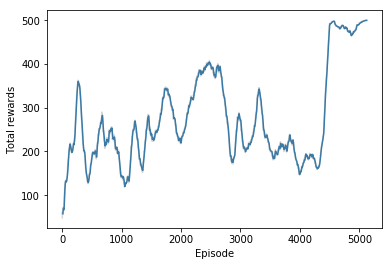

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

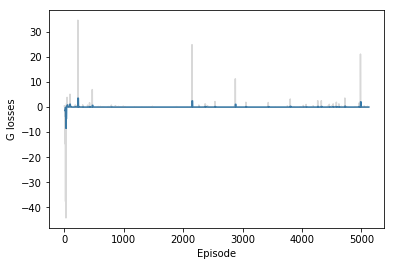

In [53]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

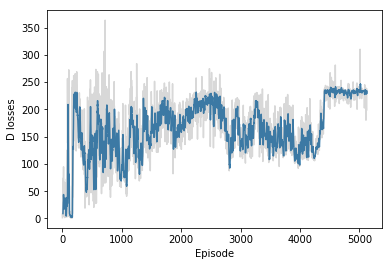

In [54]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

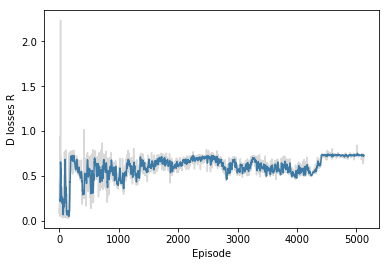

In [58]:
eps, arr = np.array(d_lossQsigm_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

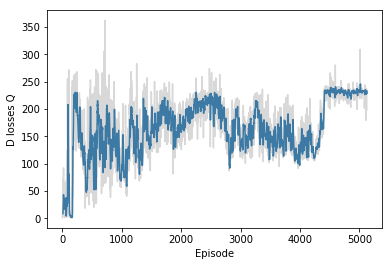

In [59]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [ ]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)

        # Training steps/batches
        while True:
            # Testing/inference
            env.render()
            action_logits, g_initial_state, d_initial_state = sess.run(
                fetches=[model.actions_logits, model.g_final_state, model.d_final_state], 
                feed_dict={model.states: np.reshape(state, [1, -1]),
                           model.g_initial_state: g_initial_state, 
                           model.d_initial_state: d_initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
# Closing the env
print('total_reward: {}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.